# Introduction to Convolutional neural networks using PyTorch 

Within this Jupyter notebook, we embark on a systematic exploration of Convolutional Neural Networks (CNNs), a class of neural networks renowned for their proficiency in processing visual data. The development has been carried out using Pytorch which is a machine learning library based on the Torch library. This tutorial encompasses a contextual backdrop and concise historical overview elucidating the evolution of CNNs.

### Questions:

1) What is a Convolutional Neural Network (CNN), and what makes it different from other types of neural networks?
2) Why are CNNs mainly used for tasks involving images?
3) How does a CNN recognize patterns in images?
4) What are the main parts of a CNN, and what do they do?
5) What is a filter in a CNN, and why is it important?
6) How do pooling layers help in CNNs?
7) What is the role of activation functions in CNNs?
8) How are CNNs trained to recognize objects in images?
9) Why is data augmentation important in training CNNs?
10) What are some common challenges in using CNNs for image recognition?
11) How can transfer learning be helpful in training CNNs?
12) What are some real-world applications of CNNs besides image recognition?

### Objectives:

- The aim of this lesson is to understand Convolutional Neural Networks, its sturcutre, why it makes the difference from the traditional neural networks.
- Reflect on case studies using CNNs: Medical Imaging Case Study.

### Prerequisits:
Follow the introduction to Neural Networks lesson.

### Datasets:
The datasets we will use will be downloaded as part of the notebook.


Before going into the details of implementation, let's explain what is CNN and what makes it different from the standard neural networks?

A Convolutional Neural Network (CNN) is a type of artificial neural network designed specifically for processing and analyzing visual data, such as images and videos. What sets CNNs apart from other types of neural networks, such as fully connected neural networks or recurrent neural networks, is their unique architecture and ability to effectively capture spatial hierarchies of features in images.

CNN's structure typically consists of several layers that perform specific operations on the input data:
- **Input Layer**: Receives the raw input data, usually images represented as matrices of pixel values.
- **Convolutional Layers**: These layers apply filters (also known as kernels) to the input image to extract features such as edges, textures, and shapes. Each filter is convolved across the input image, producing a feature map that highlights specific patterns.
- **Activation Function**: After each convolution operation, an activation function (commonly ReLU - Rectified Linear Unit) is applied element-wise to introduce non-linearity, enabling the network to learn complex patterns.
- **Pooling Layers**: These layers downsample the feature maps produced by the convolutional layers, reducing their spatial dimensions while retaining important features. Max pooling and average pooling are common techniques used for this purpose.
- **Fully Connected Layers (Dense Layers)**: After the convolutional and pooling layers, the feature maps are flattened into a vector and passed through one or more fully connected layers. These layers perform classification based on the learned features, mapping them to the output classes.
- **Output Layer**: The final layer of the CNN, typically a softmax layer for classification tasks, assigns probabilities to each class label, indicating the likelihood of the input image belonging to each class.


#### Importing Libraries.

In [2]:
### SF logs: Possible lesson title:
### 1. Deep Learning for histology slide classification, an application in colorectal cancer
### 2. Deep learning for multi-class classification of colorectal cancer histology slides
### 3. Convolutional neural networks for histology slide classification, an application in colorectal cancer

# Import the modules required:
import torch # this is the PyTorch module
import torch.nn as nn # this is the neural network module
import torch.nn.functional as F # this is the functional module
import torch.optim as optim # this is the optimizer module
import torchvision # this is the vision module

import warnings
warnings.filterwarnings("ignore") # this is to ignore warnings

# Import the MNIST dataset
from torchvision import datasets, transforms

# Import the matplotlib module
import matplotlib.pyplot as plt

# Import the numpy module
import numpy as np

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import seaborn as sns

# import medmnist, the medical image dataset
import medmnist
from medmnist import INFO, Evaluator

# fix the numpy and torch seeds for reproducibility:
SEED = 999
np.random.seed(SEED)
torch.manual_seed(SEED)

### Dataset Loading and Preprocessing

The below code cell helps us see and understand the MNIST dataset, which has images of handwritten numbers. It sets up how we'll get the data for training and testing. First, it gets the training data ready by changing the images into tensors and making them easier for the computer to handle. It does the same for the testing data. Then, it makes a way to show us some of the images with their labels, which are the numbers they represent. Finally, it grabs a bunch of images and labels from the training data and shows them to us, giving a peek into what's in the dataset.

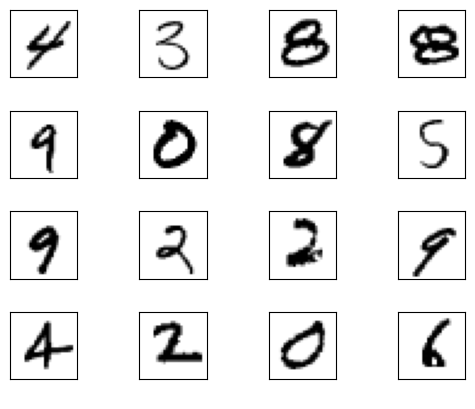

In [3]:
# Just like the previous exercise, we will use the MNIST dataset.
# PyTorch has a built-in function to download the dataset, 
# and to load it into a data loader. This is a convenient
# way to load the data into batches and apply transformations 
# to the data. We will use the data loader to load the data
# into batches of 64 images, and to normalize the images:

# define a training data loader
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                     transform=transforms.Compose([
                          transforms.ToTensor(),    # convert the image to a tensor
                          transforms.Normalize((0.1307,), (0.3081,)) # normalize the image
                        ])),
    batch_size=64, shuffle=True)

# define a test data loader
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])),
    batch_size=1000, shuffle=True)

# define a function to plot the images
def plot_images(images, labels):
    fig, axes = plt.subplots(4, 4)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(28, 28), cmap='binary')
        ax.set(xticks=[], yticks=[], xlabel=int(labels[i]))
        # make a white background for the text
        ax.xaxis.label.set_color('white')
        # increase the vertical distance between the subplots:
        fig.subplots_adjust(hspace=0.5)
    plt.show()


# plot a few of the MNIST images with their labels:
images, labels = next(iter(train_loader))
plot_images(images, labels)


## Kernels (Sliding Window)
 
 - A kernel is a small matrix (i.e. Sliding window) that is applied to the image. The kernel is moved across the image, and the dot product of the kernel and the image is computed. The output of the convolution is a feature map. The kernel is learnt during training.
 - When training a convolutional neural network, the weights in the kernels are learnt. The kernels are learnt to detect specific features in the image. For example, a kernel that detects vertical edges in the image. Many such kernels will be learnt during training. To introduce the concept of a kernel, let us define a simple kernel that detects vertical edges in the image. We will use the following kernel:

$K = \begin{bmatrix} -1 & -1 & -1 \\ -1 & 8 & -1 \\ -1 & -1 & -1 \end{bmatrix}$

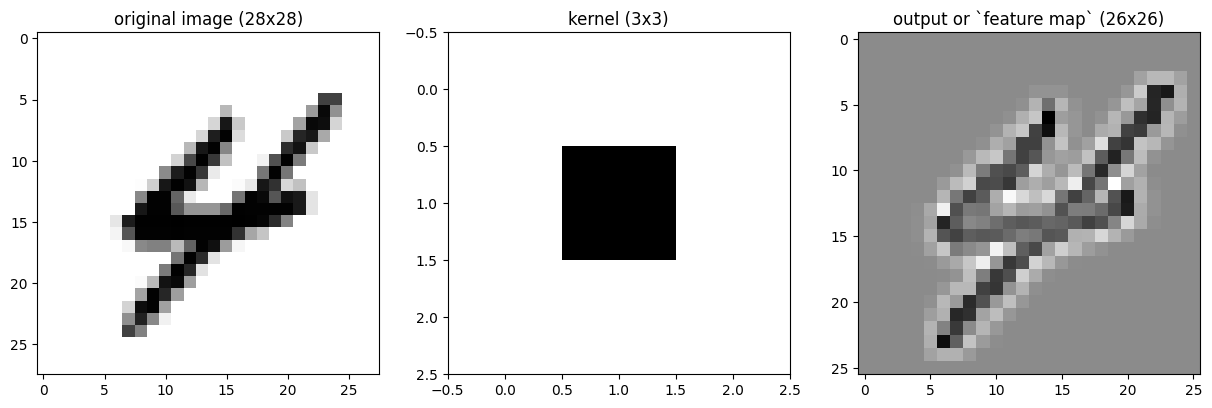

In [4]:
# Let's introduce the concept of a learnable kernel:

# Start with a 3x3 kernel with values that can be used to detect edges:
kernel = torch.tensor([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], dtype=torch.float)


# define a function to apply a kernel to an image
def apply_kernel(image, kernel):
    # get the image dimensions
    image_height, image_width = image.shape

    # get the kernel dimensions
    kernel_height, kernel_width = kernel.shape

    # calculate the output dimensions
    output_height = image_height - kernel_height + 1
    output_width = image_width - kernel_width + 1

    # initialize the output tensor
    output = torch.zeros(output_height, output_width)

    # loop through the image
    for i in range(output_height):
        for j in range(output_width):
            # get the current image patch
            image_patch = image[i:i+kernel_height, j:j+kernel_width]

            # calculate the dot product between the image patch and the kernel
            output[i, j] = torch.dot(image_patch.reshape(-1), kernel.reshape(-1))

    return output

# make a subplot of three images (original, kernel, output): Make the images bigger
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# plot the original image
axes[0].imshow(images[0][0], cmap='binary')
axes[0].set_title(f'original image ({images[0][0].shape[0]}x{images[0][0].shape[1]})')

# plot the kernel
axes[1].imshow(kernel, cmap='binary')
axes[1].set_title('kernel (3x3)')

# apply the kernel to the image
output = apply_kernel(images[0][0], kernel)

# plot the output
axes[2].imshow(output, cmap='binary')
axes[2].set_title(f'output or `feature map` ({output.shape[0]}x{output.shape[1]})')

plt.show()

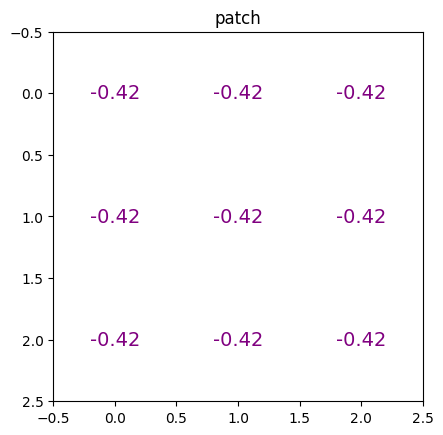

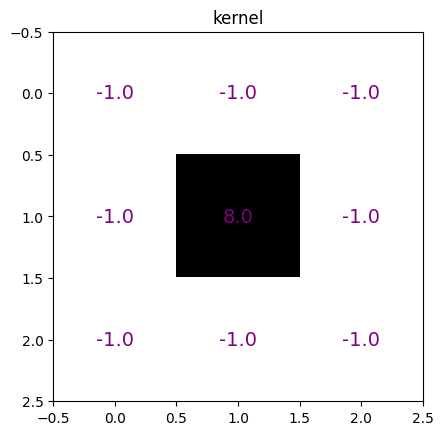

Dot product between this patch and the kernel: -0.0


In [6]:
# To illustrate what the above code does, let's take a random patch from the above input image:

# generate a random number between 0 and 27 from numpy
i = np.random.randint(0, 27)
j = np.random.randint(0, 27)


# get the 3x3 sized patch from the image
patch = images[0][0][i:i+3, j:j+3]

# plot the patch and label each pixel with the corresponding value
fig, ax = plt.subplots()
ax.imshow(patch, cmap='binary')
for i in range(patch.shape[0]):
    for j in range(patch.shape[1]):
        ax.text(j, i, round(patch[i, j].item(), 2), ha='center', va='center', color='purple', fontsize=14)
ax.title.set_text('patch')
plt.show()

# plot the kernel and label each pixel with the corresponding value
fig, ax = plt.subplots()
ax.imshow(kernel, cmap='binary')
for i in range(kernel.shape[0]):
    for j in range(kernel.shape[1]):
        ax.text(j, i, round(kernel[i, j].item(), 2), ha='center', va='center', color='purple', fontsize=14)
ax.title.set_text('kernel')
plt.show()


# calculate the dot product between the patch and the kernel
print('Dot product between this patch and the kernel:', round(torch.dot(patch.reshape(-1), kernel.reshape(-1)).item(),3) )



- These convolution operations are repeated until the entire image (blue) has been covered by the kernel. The output of the convolution is a feature map (green). Padding (white) can be added to the image to ensure that the entire image is covered by the kernel. The output of the convolution is a feature map. Remember that the kernel is learnt during training.


![ConvOperation](https://upload.wikimedia.org/wikipedia/commons/0/06/Convolution_arithmetic_-_Full_padding_no_strides.gif "conv")

### Pooling

- Pooling operations are used in convolutional neural networks to reduce the size of the feature maps. This is done to reduce the number of parameters in the network, and to reduce the amount of computation required. There are two types of pooling operations: max pooling and average pooling. Max pooling takes the maximum value from a region of the feature map. Average pooling takes the average value from a region of the feature map. The size of the region is defined by the pooling kernel. The pooling kernel is moved across the feature map, and the max or average value is computed for each region. The output of the pooling operation is a feature map. The pooling kernel is not learnt during training.



### Convolutional Neural Networks (CNNs): Implementation
 - Similarly to the previous exercise, we will use the `nn` module in PyTorch to define the layers of the network. The `nn` module has a `Sequential` class that allows us to define a network as a sequence of layers. We can also use the `nn` module to define the loss function and the optimizer.

In [7]:
# write a class to define the CNN that will be used to classify MNIST:

# define the CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # define the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1, padding=1)
        # define the second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1)
        # define the fully connected layer
        self.fc = nn.Linear(in_features=8*7*7, out_features=10)

    def forward(self, x): # use sequential to define the forward pass
        out = nn.Sequential(
            self.conv1,
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            self.conv2,
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            self.fc
        )(x)
        return out

In [8]:
# Get the MNIST data:

# define a training data loader
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                     transform=transforms.Compose([
                          transforms.ToTensor(),    # convert the image to a tensor
                          transforms.Normalize((0.1307,), (0.3081,)) # normalize the image
                        ])),
    batch_size=64, shuffle=True)

# define a test data loader
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])),
    batch_size=1000, shuffle=True)


In [9]:
# instantiate the CNN
model = CNN()

# define the loss function
criterion = nn.CrossEntropyLoss()

# define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# train the CNN

# define the number of epochs to train for
n_epochs = 5

# to track the training and test loss as the model trains
train_losses, test_losses = [], [] 

# train the model
for epoch in range(n_epochs):
    # keep track of the training and test loss
    train_loss = 0.0
    test_loss = 0.0

    # train the model
    model.train()
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

    # validate the model
    model.eval()
    for data, target in test_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average test loss
        test_loss += loss.item()*data.size(0)

    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    test_loss = test_loss/len(test_loader.sampler)

    # save the losses for plotting
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    # compute test accuracy
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # print training/validation statistics
    print(f'Epoch: {epoch+1} | Training Loss: {train_loss:.6f} | Test Loss: {test_loss:.6f} | Test Accuracy: {100*correct/total:.2f}%')


Epoch: 1 | Training Loss: 0.433374 | Test Loss: 0.164120 | Test Accuracy: 95.09%
Epoch: 2 | Training Loss: 0.138628 | Test Loss: 0.102463 | Test Accuracy: 96.92%
Epoch: 3 | Training Loss: 0.102340 | Test Loss: 0.091191 | Test Accuracy: 97.16%
Epoch: 4 | Training Loss: 0.086388 | Test Loss: 0.081364 | Test Accuracy: 97.38%
Epoch: 5 | Training Loss: 0.076285 | Test Loss: 0.071804 | Test Accuracy: 97.56%


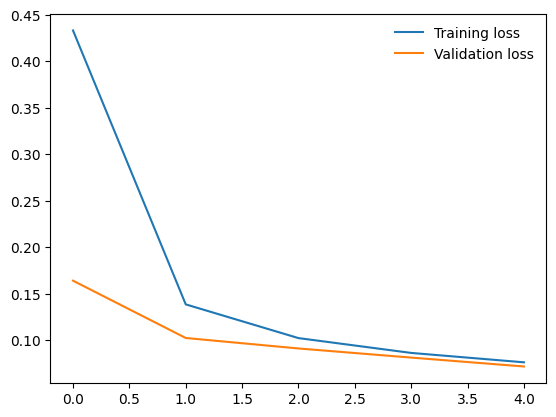

In [10]:
# plot the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

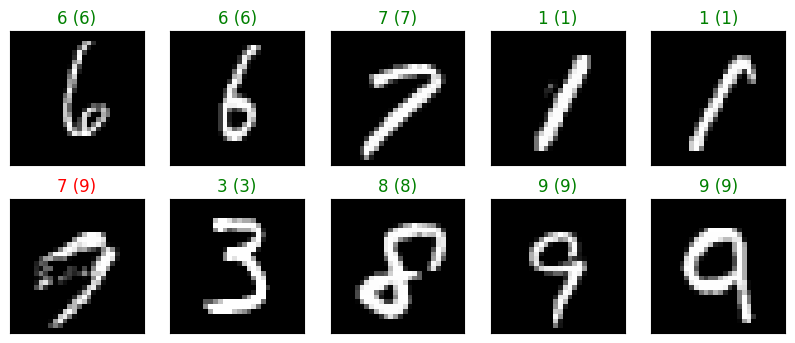

In [21]:
#****************CODE MODIFICATION*******************#
# We can now use the model to make predictions on the test set:

# obtain one batch of test images
images, labels = next(iter(test_loader))
images.numpy()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(10, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx].numpy().squeeze(), cmap='gray')
    ax.set_title(f'{preds[idx]} ({labels[idx].item()})', color=("green" if preds[idx]==labels[idx].item() else "red"))


## CNNs on medical images: Case Study

- In this exercise, we will use a convolutional neural network to classify medical images. We will use the medmnist package to make downloading these datasets easier. The  `data_flag` can be used to choose any of the following:

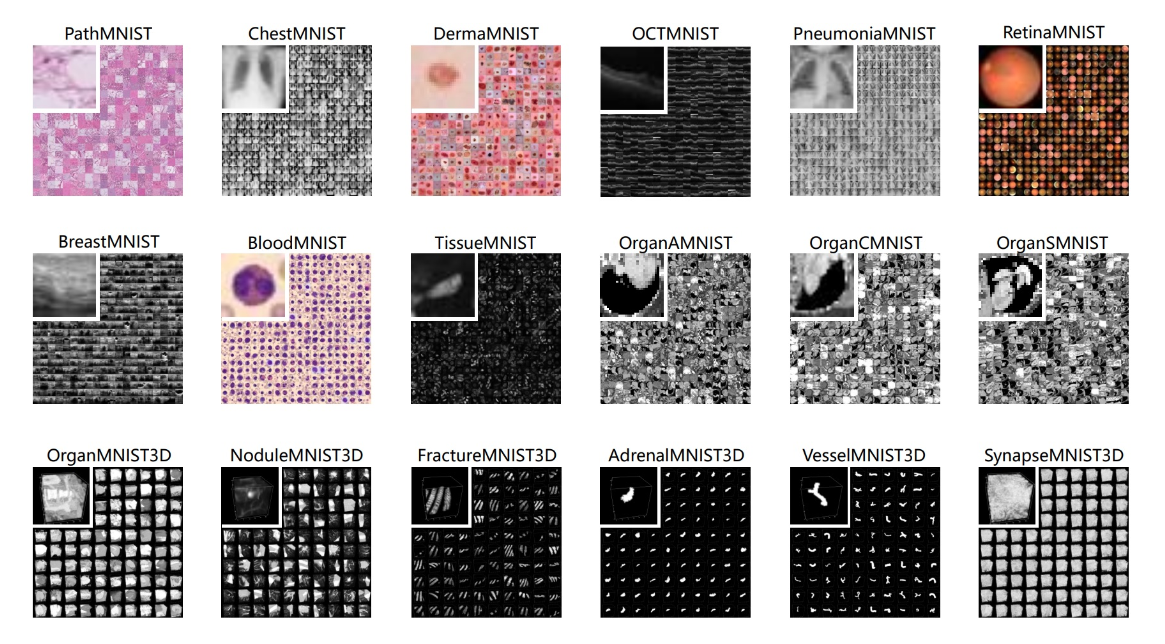

Jiancheng Yang, Rui Shi, Donglai Wei, Zequan Liu, Lin Zhao, Bilian Ke, Hanspeter Pfister, Bingbing Ni. "MedMNIST v2: A Large-Scale Lightweight Benchmark for 2D and 3D Biomedical Image Classification". arXiv preprint arXiv:2110.14795, 2021.

Jiancheng Yang, Rui Shi, Bingbing Ni. "MedMNIST Classification Decathlon: A Lightweight AutoML Benchmark for Medical Image Analysis". IEEE 18th International Symposium on Biomedical Imaging (ISBI), 2021.

We will use the PathMNIST dataset which has 107,180 colon pathology samples with 9 classes, The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set. For more information see Jakob Nikolas Kather, Johannes Krisam, et al., "Predicting survival from colorectal cancer histology slides using deep learning: A retrospective multicenter study," PLOS Medicine, vol. 16, no. 1, pp. 1–22, 01 2019.

In [11]:
import torch.utils.data as data

data_flag = 'pathmnist'
download = True

BATCH_SIZE = 128

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download, root='./data/')
test_dataset = DataClass(split='test', transform=data_transform, download=download, root='./data/')

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: ./data/pathmnist.npz
Using downloaded and verified file: ./data/pathmnist.npz
Using downloaded and verified file: /home/vscode/.medmnist/pathmnist.npz


 - Unlike the MNIST images, these pathology samples are coloured and have 3 channels (reg, green, blue) instead of 1 channel (grayscale). Each channel will be processed by a convolutional layer, and the outputs will be concatenated to form a single feature map. The feature map will then be passed through a fully connected layer to classify the image. The output of the fully connected layer will be a vector of length 9, where each element represents the probability that the image belongs to a particular class. The class with the highest probability will be the predicted class.

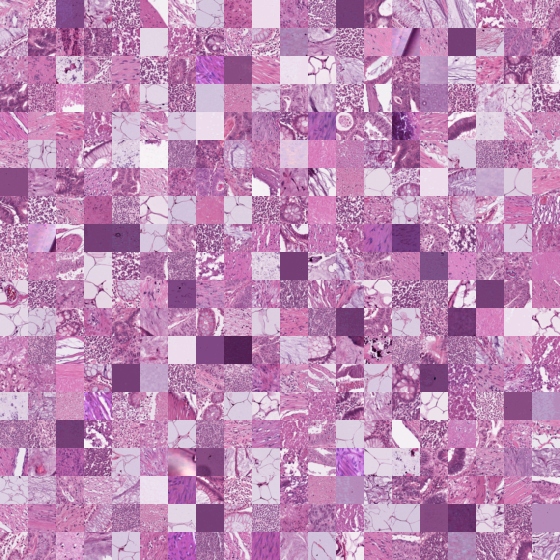

In [12]:
# Let us visualize some of the images in the dataset:
train_dataset.montage(length=20)

### Implementing CNN for Histopathology image classification

The following code snippets are implementing a Convolutional Neural Network (CNN) for Pathology image classification using PyTorch. Here's a brief summary of what it does:

- Sets up the network architecture, loss function, optimizer, and learning rate scheduler.
- Trains the model on a dataset for a specified number of epochs.
- Evaluates the model's performance on a separate test dataset.
- Implements early stopping to prevent overfitting.
- Tracks and prints the training and test loss, as well as test accuracy for each epoch.
- Saves the best performing model based on test loss.
- Finally, it loads and saves the best model's parameters.

In [13]:
# Make a new CNN_Pathology model class but with dropout layers to avoid overfitting:

class CNN_Pathology(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN_Pathology, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            # a dropout layer is added here to avoid overfitting
            nn.Dropout(p=0.6),
            nn.Linear(128, 128),
            nn.ReLU(),
            # a dropout layer is added here to avoid overfitting
            nn.Dropout(p=0.6),
            nn.Linear(128, num_classes))

    def forward(self, x):
        out = nn.Sequential(
            self.layer1,
            self.layer2,
            self.layer3,
            self.layer4,
            self.layer5)(x)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [14]:
# save the model architecture:
model = CNN_Pathology(in_channels=n_channels, num_classes=n_classes)
# save it to a file

In [15]:
# Execution time of this cell in codespaces: 67mins 06 secs
## 20 epochs took 32m:50s in codespaces
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Set the number of epochs, learning rate, and other parameters
n_epochs = 80
learning_rate = 0.001
patience = 5
lr_factor = 0.1

# Define where to run the model, i.e., CPU or GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the model, loss function, optimizer
model = CNN_Pathology(in_channels=n_channels, num_classes=n_classes)
model = model.to(device)

# define the loss function
criterion = nn.CrossEntropyLoss()

# define the optimizer, the weight decay is added to the optimizer to avoid overfitting
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.01)

# Define the learning rate scheduler; this will reduce the learning rate when the validation loss plateaus
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=lr_factor, patience=patience, verbose=True)

# Initialize variables for early stopping; early stopping avoids unnecessary training by stopping the training
# when the validation loss does not improve for a certain number of epochs (patience*4)
best_test_loss = float('inf')
best_model_params = None
epochs_no_improve = 0

# Train the model
for epoch in range(n_epochs):
    # Track the training and test loss
    train_loss = 0.0
    test_loss = 0.0

    # Train the model
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        target = target.squeeze().long()
        # Calculate the batch loss
        loss = criterion(output, target)
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # Perform a single optimization step (parameter update)
        optimizer.step()
        # Update training loss
        train_loss += loss.item() * data.size(0)

    # Validate the model
    model.eval()
    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        for data, target in test_loader:
            # Move tensors to GPU if CUDA is available
            data, target = data.to(device), target.to(device)
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            target = target.squeeze().long()
            # Calculate the batch loss
            loss = criterion(output, target)
            # Update average test loss
            test_loss += loss.item() * data.size(0)

    # Calculate average losses
    train_loss = train_loss / len(train_loader.sampler)
    test_loss = test_loss / len(test_loader.sampler)

    # Update the learning rate scheduler,
    # so it is aware of the current validation loss
    lr_scheduler.step(test_loss)

    # Save the best model based on test loss
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        # Save the model parameters for this epoch
        best_model_params = model.state_dict().copy()
        # Track the number of epochs without improvement
        epochs_no_improve = 0
    else:
        # Update the number of epochs without improvement
        epochs_no_improve += 1
        # Check early stopping condition and stop training if loss did not improve in patience*4 number of epochs
        if epochs_no_improve == patience*4:
            print(f'Early stopping after {patience*4} epochs without improvement.')
            break


    # Compute test accuracy
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            # move tensors to GPU if CUDA is available
            data, target = data.to(device), target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            target = target.squeeze().long()
            # convert output probabilities to predicted class
            _, pred = torch.max(output, 1)
            # compare predictions to true label
            correct += (pred == target).sum().item()
            total += target.size(0)


    print(f'Epoch: {epoch+1} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Test Accuracy: {100 * correct / total:.2f}%')

# Load the best model's parameters back into the model
model.load_state_dict(best_model_params)

# Save the best model
torch.save(model.state_dict(), './data/best_model.pth')

In [ ]:
# plot the training and test loss
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.title('Training and Validation Loss for the CNN on Pathology Images')
plt.show()

NameError: name 'plt' is not defined

In [ ]:
#*****************CODE MODIFICATION***************#
# Let us now visualize the predictions of the model on the test set:

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.numpy()

# move model inputs to cuda, if GPU available
images = images
labels = labels
images = torch.from_numpy(images)
images = images.to(device)
labels = labels.to(device)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)

# prep images for display
images = images.cpu().numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(20, 4))

real_labels = {
            0: "adipose",
            1: "background",
            2: "debris",
            3: "lymphocytes",
            4: "mucus",
            5: "smooth muscle",
            6: "normal colon mucosa",
            7: "cancer-associated stroma",
            8: "crc adenocarcinoma epithelium"
        }
for idx in np.arange(10):
    # get the real labels of the pathology images
    # and use these real labels to annotate the images
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.clip(np.transpose(images[idx], (1, 2, 0)), 0, 1))
    ax.set_title(f"{real_labels[int(preds[preds[idx]].cpu().numpy())]}", color=("green" if preds[idx]==labels[idx] else "red"))

In [18]:
# before we do the confusion matrix, let us first load the entire test set into memory:
test_images = []
test_labels = []
for data, target in test_loader:
    test_images.append(data)
    test_labels.append(target)

# concatenate the test images and labels
test_images = torch.cat(test_images)
test_labels = torch.cat(test_labels)

# move tensors to GPU if CUDA is available
test_images = test_images.to(device)
test_labels = test_labels.to(device)

# get sample outputs
output = model(test_images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)


In [19]:
cm = confusion_matrix(test_labels.cpu().numpy(), preds.cpu().numpy())
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=real_labels.values(), yticklabels=real_labels.values())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for the CNN on Pathology Images')
plt.show()

NameError: name 'real_labels' is not defined

<Figure size 1000x1000 with 0 Axes>

NameError: name 'real_labels' is not defined

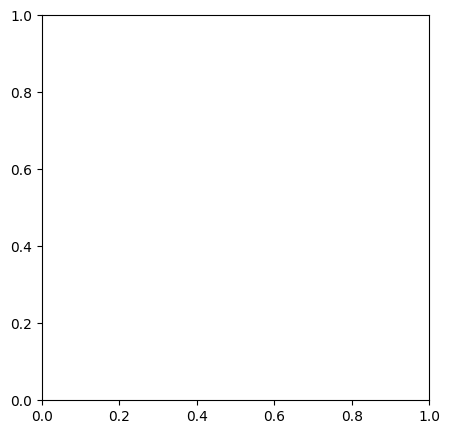

In [20]:
# Now let us do an area under the curve (AUC) analysis of the model’s performance on the test set:

# get the probabilities of the model’s predictions
probs = torch.nn.functional.softmax(output, dim=1)

# plot the ROC curve for each class in the test set as a separate curve on the same plot
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
for i in range(9):
    fpr, tpr, _ = metrics.roc_curve(test_labels.cpu().numpy() == i, probs.detach().cpu().numpy()[:, i])
    ax.plot(fpr, tpr, label=real_labels[i])
ax.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()